## 데이터셋 내려받기
- tensorflow_datasets의 tf_flowers 의 데이터 사용

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('tf_flowers',
                               split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                               with_info=True,
                               as_supervised=True) #True면 데이터를 (input, label) 튜플 형태로 반환한다. False면 데이터를 딕셔너리 형태로 반환한다.


## 데이터셋 전처리
- 같은 사이즈로 formatting
- train_batches, validation_batches, test_batches 로 나눔

In [3]:
IMG_SIZE = 160

def size_change(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [4]:
train = raw_train.map(size_change)
validation = raw_validation.map(size_change)
test = raw_test.map(size_change)

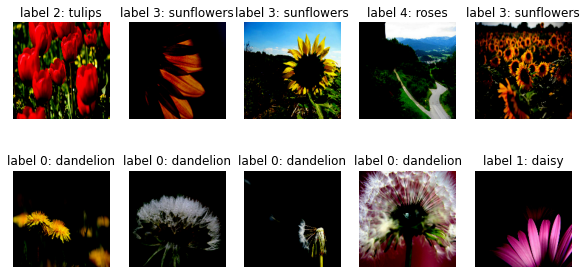

In [5]:
# 하나 꺼내서 확인하기
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    image = (image + 1) / 2
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [84]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 2000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 모델 설계하기
- VGG16 외에 다른 모델로 transfer learning

In [85]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights='imagenet')

In [86]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [87]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation ='relu')
prediction_layer = tf.keras.layers.Dense(5, activation ='softmax')

In [88]:
base_model.trainable = False

In [89]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [90]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


## 모델 학습시키기

In [91]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['accuracy'])

In [92]:
# 학습 전 모델
validation_steps = 30
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

30/30 [==============================] - 1s 26ms/step - loss: 1.6529 - accuracy: 0.2433
initial loss: 1.65
initial accuracy: 0.24


In [93]:
EPOCHES = 10
history = model.fit(train_batches,
                   epochs = EPOCHES,
                   validation_data = validation_batches)

Epoch 1/10
294/294 [==============================] - 10s 33ms/step - loss: 1.2074 - accuracy: 0.6025 - val_loss: 0.9407 - val_accuracy: 0.7166
Epoch 2/10
294/294 [==============================] - 10s 33ms/step - loss: 0.8313 - accuracy: 0.7463 - val_loss: 0.7313 - val_accuracy: 0.7493
Epoch 3/10
294/294 [==============================] - 10s 33ms/step - loss: 0.6903 - accuracy: 0.7769 - val_loss: 0.6390 - val_accuracy: 0.7766
Epoch 4/10
294/294 [==============================] - 10s 33ms/step - loss: 0.6152 - accuracy: 0.7973 - val_loss: 0.6037 - val_accuracy: 0.7875
Epoch 5/10
294/294 [==============================] - 10s 33ms/step - loss: 0.5654 - accuracy: 0.8154 - val_loss: 0.5901 - val_accuracy: 0.7629
Epoch 6/10
294/294 [==============================] - 10s 33ms/step - loss: 0.5313 - accuracy: 0.8256 - val_loss: 0.5487 - val_accuracy: 0.8011
Epoch 7/10
294/294 [==============================] - 10s 33ms/step - loss: 0.5046 - accuracy: 0.8372 - val_loss: 0.5306 - val_accuracy:

## 모델 활용하기

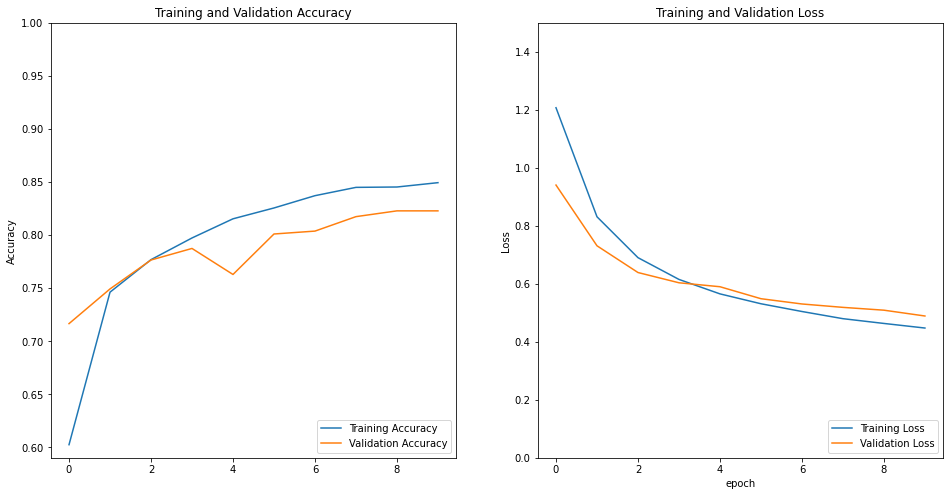

In [137]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.ylabel('Loss')
plt.ylim([0, 1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [162]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 1, 2, 2, 4, 2, 1, 0, 2, 1])

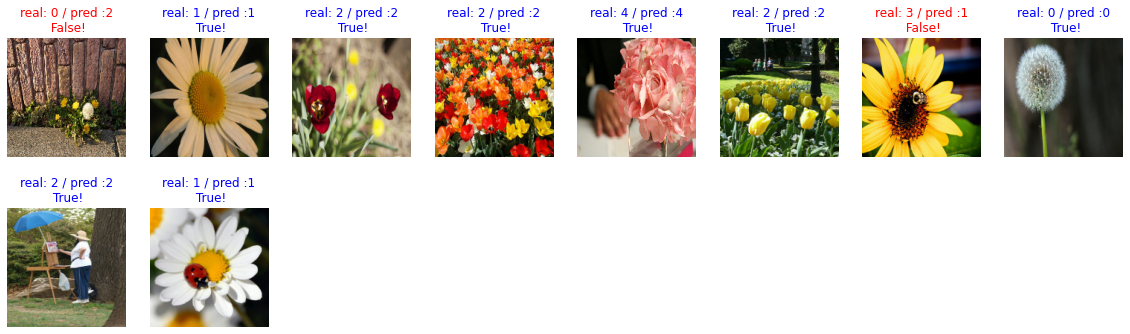

In [164]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    plt.axis('off')
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})